# PDCalibration d-spacing

It looks like the PDCalibration does not calibrate difc too well.
It gives values of difc that is 1% off.
This notebook shows that.

Basically, this notebook

* Loads the data
* Run PDCalibration to obtain difc
* In the diagnostic result of PDCalibration, we can get d-spacing value of peaks for any pixel, which Pete claims that it is the calibrated d-spacing value (computed using calibrated difc).
* Use difc to align the detectors
* Compute I(d) of one pixel. Visual inspection shows that the d-spacing does not match the value in the diagnostic workspace.

In [1]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import os, numpy as np
from mantid import simpleapi as msa, mtd

In [3]:
dvalues = [1.10860231, 1.24596143, 1.357755, 1.63751414, 1.92015553, 3.13560085]

In [4]:
signal = msa.Load('/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5')

In [ ]:
%%time
msa.PDCalibration(
    SignalWorkspace="signal",
    TofBinning=[300,-.001,16666.7],
    PeakPositions=dvalues,
    StartFromObservedPeakCentre=True,
    OutputCalibrationTable='new_cal',
    DiagnosticWorkspaces='cal_diag',
    CalibrationParameters='DIFC')

In [31]:
msa.SaveNexus(new_cal, 'difc_cal')

TableWorkspace
Columns: 6
Rows: 115712
4 MB

In [30]:
new_cal = mtd['new_cal']
new_cal.getColumnNames()

['detid', 'difc', 'difa', 'tzero', 'tofmin', 'tofmax']

In [7]:
cal_diag = mtd['cal_diag']
cal_diag_d = cal_diag[0]
cal_diag_d.getColumnNames()

['detid',
 '@1.1086',
 '@1.246',
 '@1.3578',
 '@1.6375',
 '@1.9202',
 '@3.1356',
 'chisq',
 'normchisq']

In [8]:
d31356 = np.array(cal_diag_d.column('@3.1356'))
d31356[100455]

3.1356009137224281

In [ ]:
d31356[d31356==d31356]

In [9]:
%%time
ws = msa.Load(Filename="/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5")

CPU times: user 57.1 s, sys: 12.7 s, total: 1min 9s
Wall time: 16.4 s


In [10]:
ws = msa.CropWorkspace(InputWorkspace=ws, XMin=300, XMax=16666.7)

In [12]:
msa.AlignDetectors(InputWorkspace=ws, OutputWorkspace='aligned', CalibrationWorkspace='new_cal')

EventWorkspace
Title: Si powder, White beam, Ei set to 250meV T0=30
Histograms: 115712
Bins: 1
Histogram
X axis: d-Spacing / Angstrom
Y axis: Counts
Distribution: False
Instrument: SEQUOIA (2012-Apr-04 to 2100-Jan-31)Instrument from: /SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5

Parameters from: /home/lj7/dv/mantid/mantid/instrument/SEQUOIA_Parameters.xml
Run start: 2017-Jul-14 04:26:01
Run end:  2017-Jul-14 06:21:57

Events: 1208193525

In [14]:
msa.CropWorkspace(InputWorkspace='aligned', OutputWorkspace='aligned',XMin=0.4, XMax=7)

EventWorkspace
Title: Si powder, White beam, Ei set to 250meV T0=30
Histograms: 115712
Bins: 1
Histogram
X axis: d-Spacing / Angstrom
Y axis: Counts
Distribution: False
Instrument: SEQUOIA (2012-Apr-04 to 2100-Jan-31)Instrument from: /SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5

Parameters from: /home/lj7/dv/mantid/mantid/instrument/SEQUOIA_Parameters.xml
Run start: 2017-Jul-14 04:26:01
Run end:  2017-Jul-14 06:21:57

Events: 1123204982

In [15]:
I_d = msa.Rebin(InputWorkspace='aligned', Params='0.4,-0.001,7')

In [16]:
I_d_100455 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=100455, EndWorkspaceIndex=100455)

<IPython.core.display.Javascript object>


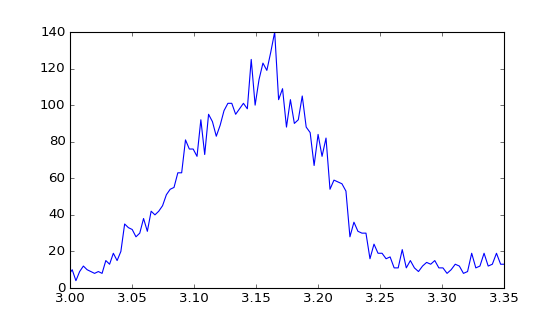

(3, 3.35)

In [17]:
plt.figure(figsize=(7,4))
Xbb = I_d_100455.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_100455.readY(0))
plt.xlim(3,3.35)

Simple fitting

In [18]:
import scipy.optimize as sopt

In [19]:
x = (Xbb[:-1]+Xbb[1:])/2
y = I_d_100455.readY(0)

In [23]:
np.where(x>3)[0][0], np.where(x<3.3)[0][-1]

(2016, 2110)

In [24]:
x1 = x[2016:2110]
y1 = y[2016:2110]

In [27]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [28]:
sopt.curve_fit(gauss, x1, y1, p0=(100, 3.13, 0.1))

(array([  1.11542761e+02,   3.14945162e+00,   5.71292906e-02]),
 array([[  3.18134535e+00,  -1.02880159e-06,  -1.10383722e-03],
        [ -1.02880159e-06,   1.10983225e-06,   2.13877770e-08],
        [ -1.10383722e-03,   2.13877770e-08,   1.13484408e-06]]))

center = 3.1495. looks right. different from results of PDCalbiration